In [1]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Machine Learning Preprocessing and Scoring Metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RepeatedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import psutil
import os

# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC, SVR
from tpot import TPOTClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

c:\Users\Elija\anaconda3\envs\Cohort_Env\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
df = pd.read_csv('data.csv', index_col='date', parse_dates=["date"])
df.drop(columns=['open', 'high', 'low', 'adj_close'], inplace=True)     # Colinear features observed from EDA notebook
df.head()

,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,
2000-01-03,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


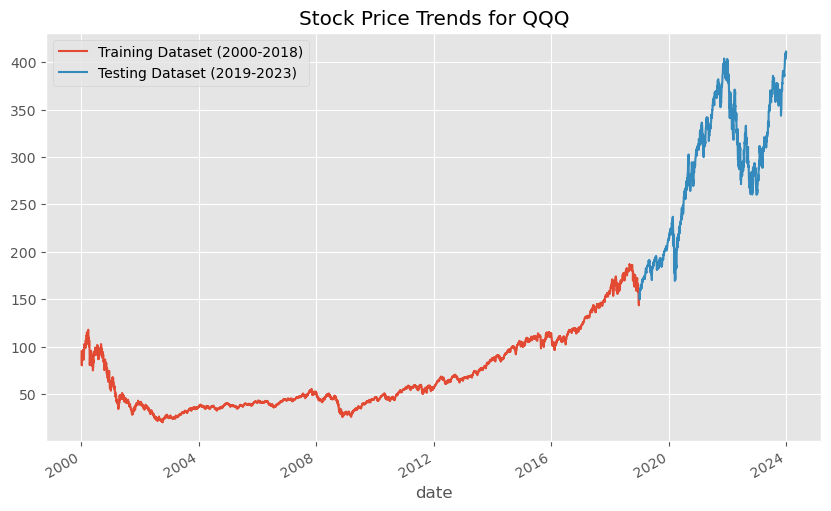

In [3]:
df['close'][:'2018-12-31'].plot(figsize=(10,6), legend=True)
df['close']['2019-01-01':].plot(figsize=(10,6), legend=True)

plt.legend(["Training Dataset (2000-2018)", "Testing Dataset (2019-2023)"])
plt.title("Stock Price Trends for QQQ")
plt.show()

In [4]:
train = df[df.index <= '2018-12-31']
test = df[df.index > '2018-12-31']

In [5]:
X_train  = train.reset_index()
X_train.drop(columns=['date', 'close'], inplace=True)
display(X_train.head())

X_test  = test.reset_index()
X_test.drop(columns=['date', 'close'], inplace=True)
display(X_test.head())

,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,36345200,5.43,7.5,2.826171,4.1,111.3
1,33786600,5.38,7.5,2.826171,4.1,111.3
2,42496600,5.41,7.5,2.826171,4.1,111.3
3,37134800,5.54,7.5,2.826171,4.1,111.3
4,28138200,5.61,7.5,2.826171,4.1,111.3


,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
0,58576700,2.4,3.4,1.233584,3.8,93.8
1,74820200,2.4,3.4,1.233584,3.8,93.8
2,74709300,2.4,3.4,1.233584,3.8,93.8
3,52059300,2.4,3.4,1.233584,3.8,93.8
4,49388700,2.4,3.4,1.233584,3.8,93.8


In [6]:
y_train = train.reset_index()
y_train = y_train['close']
display(y_train.head())

y_test = test.reset_index()
y_test = y_test['close']
display(y_test.head())

0    94.75000
1    88.25000
2    86.00000
3    80.09375
4    90.00000
Name: close, dtype: float64

0    154.880005
1    149.820007
2    156.229996
3    158.089996
4    159.520004
Name: close, dtype: float64

In [7]:
mm_scaler = MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [8]:
def test_regression_models(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'neg_mean_squared_error' 
    
    # Define the models to be tested
    models = {
        "Linear Regression": LinearRegression(),
        "K-Nearest Neighbors": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Support Vector Regressor": SVR()
    }
    
    # Initialize results dictionary to store metrics for each model
    results = {
        "Model": [],
        "Mean Squared Error": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Perform model evaluation for each model
    for model_name, model in models.items():
        # Measure training time
        start_train_time = time.time()

        # Perform k-fold cross-validation to evaluate the model on the training data
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure memory usage (in MB)
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        
        # Convert MSE scores to positive values
        mse_scores = -cv_scores

        # Store the metrics in the results dictionary
        results["Model"].append(model_name)
        results["Mean Squared Error"].append(round(np.mean(mse_scores), 4))
        results["Spread (std)"].append(round(np.std(mse_scores), 4))
        results["Train Time (s)"].append(round(train_time, 4))
        results["Memory Usage (MB)"].append(round(memory_usage, 0))
        
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    
    # Print the results
    return results_df


In [9]:
test_regression_models(X_train_scaled, y_train)

,Model,Mean Squared Error,Spread (std),Train Time (s),Memory Usage (MB)
0,Linear Regression,1443.1902,1629.9934,0.0382,381.0
1,K-Nearest Neighbors,681.0830,968.1471,0.1344,381.0
2,Decision Tree,1809.2469,2229.9879,0.4146,382.0
3,Random Forest,1583.2468,2267.3146,32.3059,384.0
4,Gradient Boosting,1147.2363,2062.9006,8.1281,385.0
5,XGBoost,1443.2812,2204.5573,1.0252,392.0
6,Support Vector Regressor,761.3741,1391.4371,13.0733,388.0


Best performing model was the KNN. Let's see if we can boost performance.

___

___

### KNN

In [10]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 7, 11],
    'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30, 40],
    'p': [1,2],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

In [11]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=True)

In [12]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 40],
                         'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [3, 7, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [13]:
best_knn = grid_search.best_estimator_
best_knn

KNeighborsRegressor(leaf_size=20, n_neighbors=3, p=1, weights='distance')

In [14]:
best_score = grid_search.best_score_
best_score

-4.590323358902087

In [15]:
best_knn_pred = best_knn.predict(X_test_scaled)

In [16]:
best_knn_r2 = r2_score(y_test, best_knn_pred)
best_knn_r2

-11.617642506142317

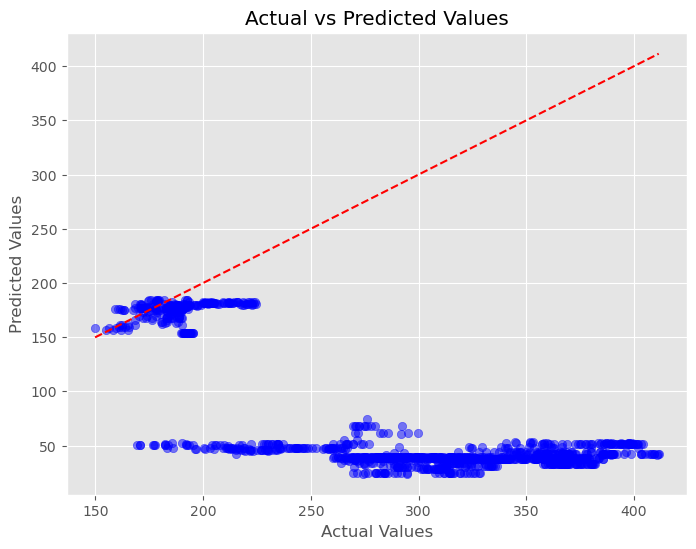

In [17]:
plt.figure(figsize=(8, 6))

# Scatter plot for actual vs predicted values
x = y_test
y = best_knn_pred
plt.scatter(x, y, color='blue', alpha=0.5)

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


# Line showing perfect predictions
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle='--')

plt.show()


Interpretation:

Even best KNN is unable to perform well on predictive task.

___

In [18]:
X_train_scaled.shape

(4779, 6)

In [19]:
# Function to create window for given timesteps
def create_window(data, target, timesteps):
    X, y = [], []
    for i in range (timesteps, len(data)):
        X.append(data[i-timesteps: i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [20]:
# Fit to scaled data with timesteps=30
X_train_rnn, y_train_rnn = create_window(X_train_scaled, y_train, 30)
X_test_rnn, y_test_rnn = create_window(X_test_scaled, y_test, 30)

In [21]:
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model.add(Dense(1))  # Output layer for regression

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2850      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=30, batch_size=32)

Epoch 1/30
149/149 [==============================] - 3s 11ms/step - loss: 5006.5083 - val_loss: 81030.4922
Epoch 2/30
149/149 [==============================] - 1s 7ms/step - loss: 3966.8401 - val_loss: 76975.8984
Epoch 3/30
149/149 [==============================] - 1s 7ms/step - loss: 3332.1897 - val_loss: 73470.8906
Epoch 4/30
149/149 [==============================] - 1s 8ms/step - loss: 2844.9641 - val_loss: 70374.4766
Epoch 5/30
149/149 [==============================] - 1s 7ms/step - loss: 2472.9043 - val_loss: 67629.4062
Epoch 6/30
149/149 [==============================] - 1s 7ms/step - loss: 2193.7480 - val_loss: 65236.8594
Epoch 7/30
149/149 [==============================] - 1s 7ms/step - loss: 1989.0137 - val_loss: 63166.4688
Epoch 8/30
149/149 [==============================] - 1s 7ms/step - loss: 1842.8484 - val_loss: 61379.8125
Epoch 9/30
149/149 [==============================] - 1s 7ms/step - loss: 1742.7972 - val_loss: 59880.4297
Epoch 10/30
149/149 [===============

In [23]:
# Function to plot Loss by Epoch
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss by Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    return plt.show()

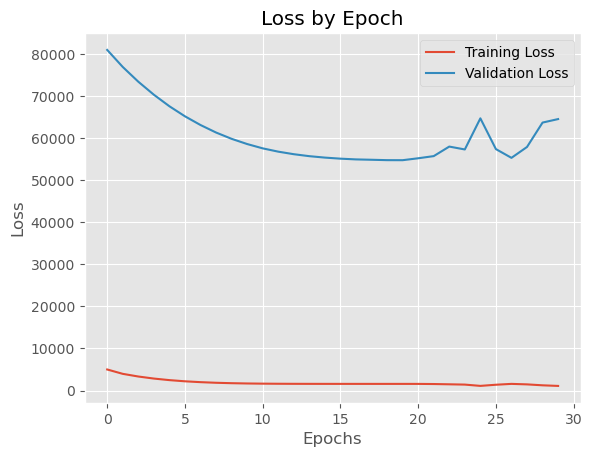

In [24]:
plot_loss(history)

Despite a steady decline in loss for the training function, the model is still failiing to perform on well on test data.